In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import generate_IPP, lamda

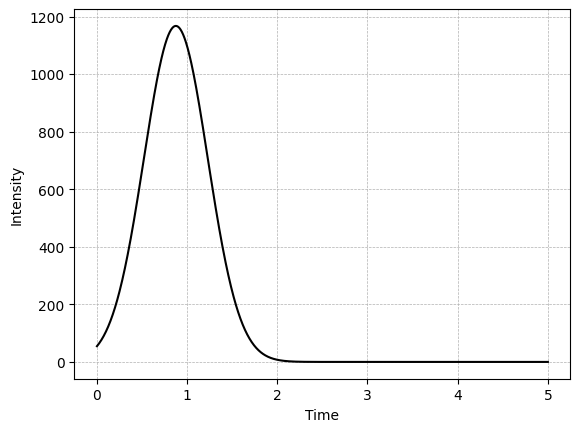

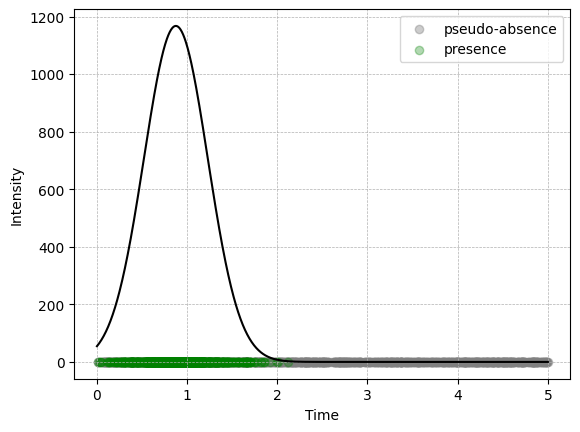

Number of presence: 992
Number of absence: 1000


In [2]:
beta_true = np.array([4, 7, -4])
n0 = 1000
Z = 100000
T = 5

X, y, t, z = generate_IPP(T, beta_true, n0, Z, verbose=True)


print(f"Number of presence: {len(y[y == 1])}")
print(f"Number of absence: {n0}")

In [3]:
import scipy.optimize as opt

# ロジスティック回帰モデルの最尤推定


# シグモイド関数
def sigmoid(x):
    """Numerically stable sigmoid function."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))


def negative_log_likelihood(beta, X, y, z):
    h = sigmoid(X @ beta)
    return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))


beta_hat = opt.fmin_bfgs(
    negative_log_likelihood, np.random.normal(size=3), args=(X, y, z)
)

beta_hat

         Current function value: 11229.079904
         Iterations: 75
         Function evaluations: 427
         Gradient evaluations: 106


/tmp/ipykernel_222761/803783411.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_222761/803783411.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(h) + (1 - y) * z * np.log(1 - h))
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


array([-12.70261802,   6.40840596,  -3.64009156])

## 繰り返し推定して漸近的性質を確認

In [6]:
beta_true = np.array([2, 7, -4])

n0_candidates = np.array([10, 100, 1000, 10000])
Z_candidates = np.array([1, 10, 100, 1000, 10000, 100000])

n_estimate = 1000
beta_estimated = np.empty((n_estimate, len(n0_candidates), len(Z_candidates), 3))
n1_estimated = np.empty((n_estimate, len(n0_candidates), len(Z_candidates)))

# warningを非表示
import warnings

warnings.filterwarnings("ignore")
for i in tqdm(range(n_estimate)):
    for j, n0 in enumerate(n0_candidates):
        for k, Z in enumerate(Z_candidates):
            X, y, t, z = generate_IPP(T, beta_true, n0, Z)
            n1_estimated[i, j, k] = len(y[y == 1])
            beta_estimated[i, j, k] = opt.fmin_bfgs(
                negative_log_likelihood,
                np.random.normal(size=3),
                args=(X, y, z),
                disp=False,
            )

beta_estimated.to_csv("output/beta_estimated.csv")

100%|██████████| 1000/1000 [36:36<00:00,  2.20s/it]


AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [4]:
beta_estimated = pd.read_csv("output/beta_estimated.csv", header=None).values.reshape(
    1000, 4, 6, 3
)
beta_estimated.shape

(1000, 4, 6, 3)

In [5]:
beta_pred = beta_estimated[:, 1, 3, :]
beta_pred = beta_pred[np.all(np.abs(beta_pred) < 100, axis=1)]
beta_pred.shape

(895, 3)

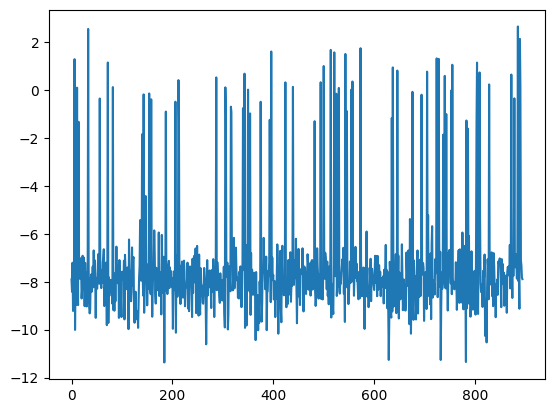

In [10]:
plt.plot(beta_pred[:, 0])

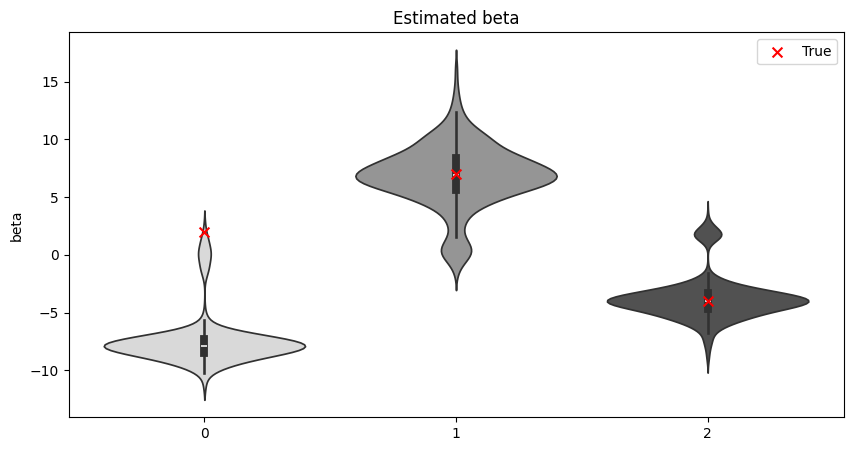

In [11]:
plt.figure(figsize=(10, 5))
# violinplot
import seaborn as sns

sns.violinplot(data=beta_pred, palette="Greys")
plt.scatter([0, 1, 2], beta_true, c="red", label="True", marker="x", s=50, zorder=10)

plt.title("Estimated beta")  # グラフのタイトル
plt.ylabel("beta")  # ｙ軸ラベル
plt.xlabel("")  # x軸ラベルの消去
plt.legend()

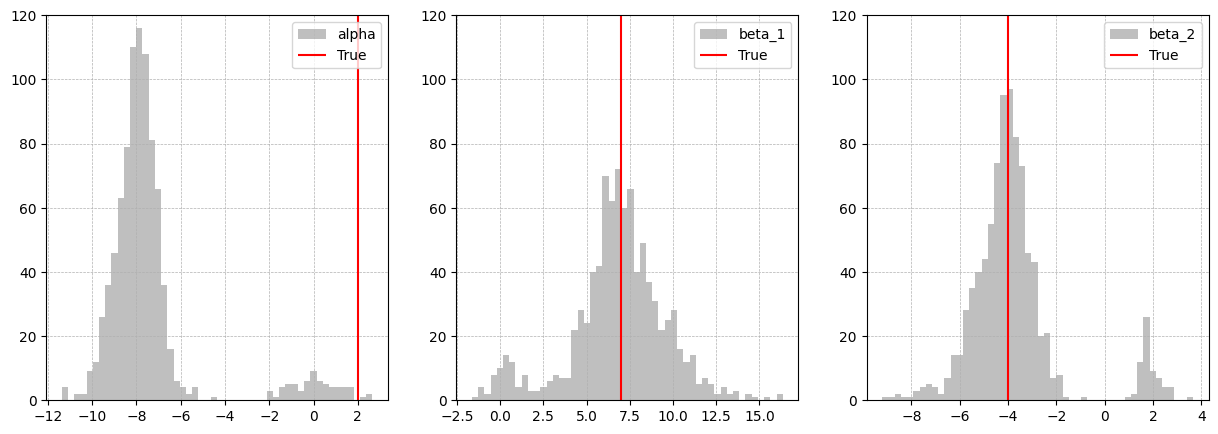

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(beta_pred[:, 0], bins=50, color="grey", alpha=0.5, label="alpha")
plt.vlines(beta_true[0], 0, 150, color="red", label="True")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(beta_pred[:, 1], bins=50, color="grey", alpha=0.5, label="beta_1")
plt.vlines(beta_true[1], 0, 150, color="red", label="True")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(beta_pred[:, 2], bins=50, color="grey", alpha=0.5, label="beta_2")
plt.vlines(beta_true[2], 0, 150, color="red", label="True")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.ylim(0, 120)
plt.legend()

In [13]:
beta_mean = beta_pred.mean(axis=0)
beta_mean

array([-7.40275797,  6.83990071, -3.77293366])

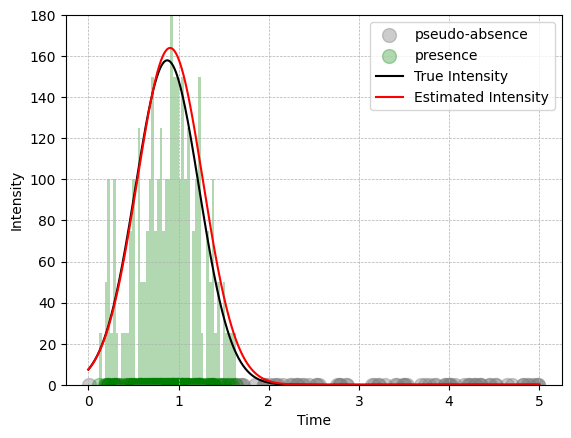

In [14]:
plt.scatter(t0, np.zeros(n0), c="grey", alpha=0.4, label="pseudo-absence", s=100)
plt.scatter(t1, np.zeros(len(t1)), c="green", alpha=0.3, label="presence", s=100)


plt.hist(t1, bins=50, color="green", alpha=0.3, weights=25 * np.ones(len(t1)))
plt.hist(t0, bins=50, color="grey", alpha=0.3, weights=np.ones(len(t0)) / 10)
t_lin = np.linspace(0, 5, 1000)
X_lin = np.vstack([np.ones(1000), t_lin, t_lin**2]).T
plt.plot(t_lin, lamda(t_lin, beta_true), c="black", label="True Intensity")

# for beta in beta_pred:
#    plt.plot(t_lin, lamda(t_lin, beta), c='black', alpha=0.1)

beta_mean[0] = 2
plt.plot(t_lin, lamda(t_lin, beta_mean), c="red", label="Estimated Intensity")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.ylim(0, 180)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

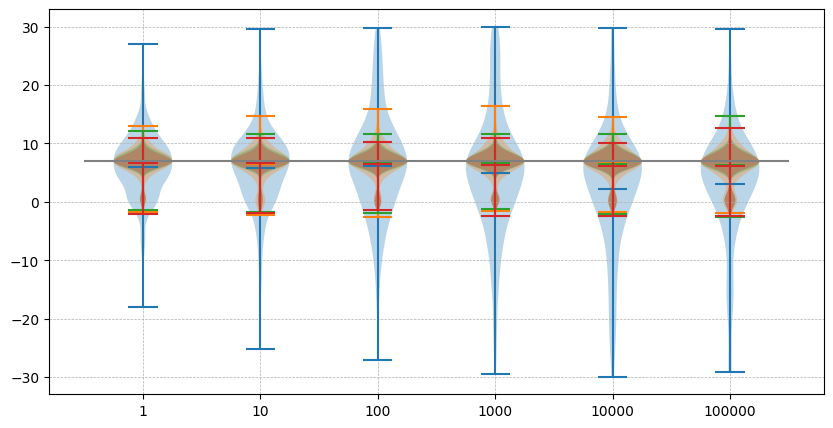

In [15]:
betas_list_list = []
for i in range(4):
    betas_list = []
    for j in range(6):
        betas = beta_estimated[:, i, j, 1]
        betas = betas[np.abs(betas) < 30]
        betas_list.append(betas)
    betas_list_list.append(betas_list)

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.violinplot(betas_list_list[i], showmeans=True, showmedians=False)

plt.hlines(beta_true[1], 0.5, 6.5, color="grey", label="True")
plt.xticks([1, 2, 3, 4, 5, 6], Z_candidates)
plt.grid(True, linestyle="--", linewidth=0.5)

plt.show()

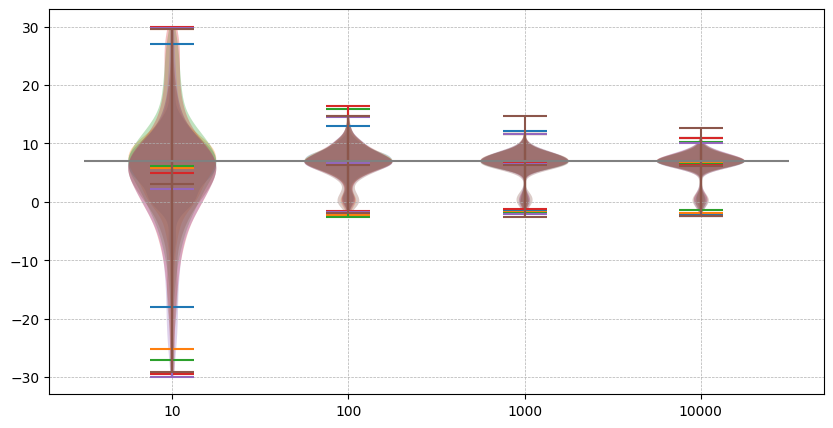

In [16]:
betas_list_list = []
for i in range(6):
    betas_list = []
    for j in range(4):
        betas = beta_estimated[:, j, i, 1]
        betas = betas[np.abs(betas) < 30]
        betas_list.append(betas)
    betas_list_list.append(betas_list)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.violinplot(betas_list_list[i], showmeans=True, showmedians=False)

plt.hlines(beta_true[1], 0.5, 4.5, color="grey", label="True")
plt.xticks([1, 2, 3, 4], n0_candidates)
plt.grid(True, linestyle="--", linewidth=0.5)

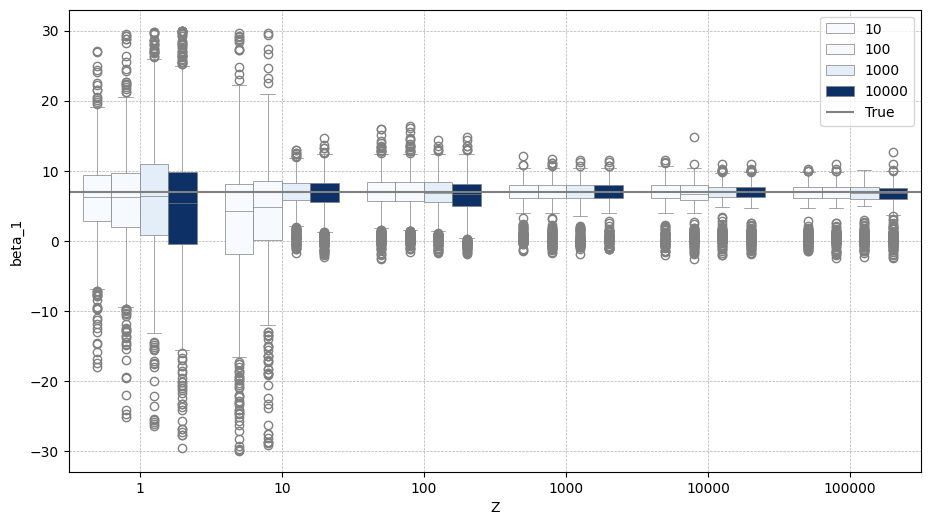

In [17]:
beta_df = pd.DataFrame(
    beta_estimated.reshape(-1, 3), columns=["alpha", "beta_1", "beta_2"]
)
beta_df["n0"] = np.tile(n0_candidates, 6000)
beta_df["Z"] = np.tile(np.repeat(Z_candidates, 4), 1000)

beta_df = beta_df[beta_df["alpha"].abs() < 30]
beta_df = beta_df[beta_df["beta_1"].abs() < 30]
beta_df = beta_df[beta_df["beta_2"].abs() < 30]

plt.figure(figsize=(11, 6))
sns.boxplot(
    x="Z",
    y="beta_1",
    data=beta_df,
    hue="n0",
    palette="Blues",
    saturation=0.9,
    linewidth=0.5,
    linecolor="grey",
)
plt.hlines(beta_true[1], -1, 6, color="grey", label="True")
plt.xlim(-0.5, 5.5)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)

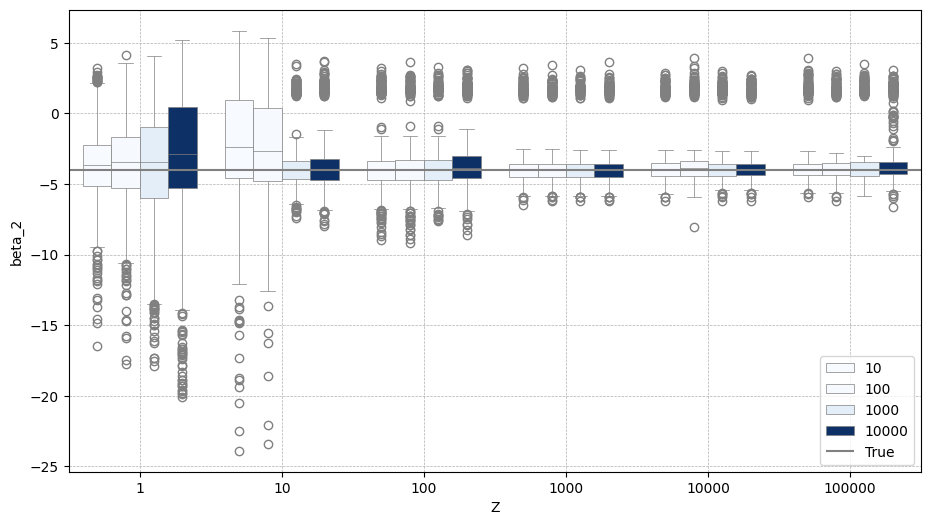

In [18]:
beta_df = pd.DataFrame(
    beta_estimated.reshape(-1, 3), columns=["alpha", "beta_1", "beta_2"]
)
beta_df["n0"] = np.tile(n0_candidates, 6000)
beta_df["Z"] = np.tile(np.repeat(Z_candidates, 4), 1000)

beta_df = beta_df[beta_df["alpha"].abs() < 30]
beta_df = beta_df[beta_df["beta_1"].abs() < 30]
beta_df = beta_df[beta_df["beta_2"].abs() < 30]

plt.figure(figsize=(11, 6))
sns.boxplot(
    x="Z",
    y="beta_2",
    data=beta_df,
    hue="n0",
    palette="Blues",
    saturation=0.9,
    linewidth=0.5,
    linecolor="grey",
)
plt.hlines(beta_true[2], -1, 6, color="grey", label="True")
plt.xlim(-0.5, 5.5)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)

In [19]:
beta_df

,alpha,beta_1,beta_2,n0,Z
0,3.525377,4.443085,-3.444857,10,1
1,2.309933,1.712174,-2.090906,100,1
2,1.366759,-1.143148,-0.814968,1000,1
3,1.064363,-4.587978,0.433157,10000,1
4,-0.136105,-6.166385,0.833543,10,10
...,...,...,...,...,...
23993,-14.714047,7.206776,-4.137298,100,10000
23994,0.696657,0.665907,1.763454,1000,10000
23995,-7.414116,5.182205,-2.942134,10000,10000
23996,-9.716407,5.181431,-2.941756,10,100000
